In [2]:
# Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os, json, joblib
from datetime import datetime
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


### Load Data

In [3]:
# Load the training datasets
data = pd.read_csv('./data/feature_engineered_epc_dom.csv')

# Prepare target columns
## Drop cur_rate because it will not be the target but highly correlates with it
data.drop(columns=['cur_rate'], inplace=True)

# Define feature and target columns
feature_cols = data.drop(columns=['cur_ee', 'per_ee']).columns.to_list()
target_col_current = 'cur_ee'
target_col_potential = 'per_ee'

# Separate features and target
X = data[feature_cols]
y_current = data[target_col_current]
y_potential = data[target_col_potential]

# Check data
X.head(15)

,b_type,p_type,tenure,area,water_ee,wind_ee,wall_ee,roof_ee,heat_ee,con_ee,light_ee,pv,sol_wat,quality_index,build_year,building_age,fuel_group,is_community_heating,has_boiler,has_air_hp,has_ground_hp,has_micro_chp,has_community,has_storage_heaters,has_room_heaters,has_electric_underfloor,has_electric_ceiling,has_radiators,has_underfloor,has_warm_air,uses_gas,uses_oil,uses_electricity,uses_biomass,uses_coal,floor_type,floor_boundary,floor_insulation,floor_u_value,floor_ins_num,dhw_no_cylinder_stat,dhw_has_solar,dhw_has_waste_heat,dhw_system,dhw_energy,wall_type,wall_insulation,wall_u_value,roof_type,roof_boundary,roof_insulation_type,roof_insulation_mm,roof_u_value,has_time_control,has_temp_control,has_room_control,glazing_type,glazing_quality,glazing_level,glazing_coverage
0,semi-detached,bungalow,rented (social),45.0,4,3,3,4,4,4,5,no,no,4.0,1958,66,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,suspended,ground,none,NaN,0.0,0,0,0,boiler,unknown,cavity,filled_cavity,NaN,pitched,external,loft,270.0,NaN,1,1,1,double,unknown,double,full
1,mid-terrace,house,rented (social),87.0,4,3,3,5,4,3,5,no,no,4.0,1971,53,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,solid,ground,none,NaN,0.0,0,0,0,boiler,unknown,cavity,filled_cavity,NaN,pitched,external,loft,300.0,NaN,1,1,0,double,unknown,double,full
2,detached,house,owner-occupied,174.0,4,3,3,5,4,4,5,no,no,4.2,1915,109,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,suspended,ground,none,NaN,0.0,0,0,0,boiler,unknown,cavity,filled_cavity,NaN,pitched,external,loft,300.0,NaN,1,1,1,double,modern,double,partial
3,semi-detached,house,owner-occupied,84.0,2,4,3,3,4,3,4,no,no,3.4,1971,53,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,solid,ground,none,NaN,0.0,1,0,0,boiler,unknown,cavity,filled_cavity,NaN,pitched,external,loft,100.0,NaN,1,1,0,double,modern,double,full
4,detached,house,owner-occupied,89.0,4,3,2,4,4,4,5,no,no,3.8,1971,53,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,suspended,ground,none,NaN,0.0,0,0,0,boiler,unknown,cavity,none,NaN,pitched,external,loft,150.0,NaN,1,1,1,double,unknown,double,full
5,mid-terrace,house,owner-occupied,73.0,4,3,1,4,4,3,5,no,no,3.4,1940,84,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,suspended,ground,none,NaN,0.0,0,0,0,boiler,unknown,solid,none,NaN,pitched,external,loft,150.0,NaN,1,1,0,double,old,double,full
6,mid-terrace,house,rented (private),105.0,4,4,1,4,4,4,5,no,no,3.6,1915,109,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,suspended,ground,none,NaN,0.0,0,0,0,boiler,unknown,solid,none,NaN,pitched,external,loft,200.0,NaN,1,1,1,double,modern,double,full
7,mid-terrace,flat,owner-occupied,54.0,3,3,4,4,3,2,3,no,no,3.2,1993,31,electricity,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,unknown,dwelling_below,unknown,NaN,NaN,0,0,0,electric_immersion,electricity,cavity,insulated_as_built,NaN,pitched,external,loft,200.0,NaN,1,0,0,double,old,double,full
8,mid-terrace,house,rented (private),51.0,4,3,4,4,4,1,5,no,no,3.6,1986,38,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,solid,ground,none,NaN,0.0,0,0,0,boiler,unknown,timber_frame,insulated_as_built,NaN,pitched,external,loft,150.0,NaN,1,1,0,double,unknown,double,full
9,end-terrace,flat,rented (private),39.0,4,4,4,0,4,4,5,no,no,3.4,2009,15,gas,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,unknown,external_air,insulated,NaN,2.0,0,0,0,boiler,unknown,system_built,insulated_as_built,NaN,dwelling_above,dwelling_above,unknown,NaN,NaN,1,1,1,double,modern,double,full


### Preprocess Features

In [4]:
categorical_features = [
    "b_type", "p_type", "tenure", "fuel_group", "floor_type", "floor_boundary", "floor_insulation",
    "dhw_system", "dhw_energy", "wall_type", "wall_insulation", "roof_type", "roof_boundary", "roof_insulation_type",
    "glazing_type", "glazing_quality", "glazing_level", "glazing_coverage", "sol_wat", "pv"
]

numeric_features = [
    "area", "water_ee", "wind_ee", "wall_ee", "roof_ee", "heat_ee", "con_ee", "light_ee",
    "quality_index", "build_year", "building_age", "is_community_heating",
    "has_boiler", "has_air_hp", "has_ground_hp", "has_micro_chp", "has_community",
    "has_storage_heaters", "has_room_heaters", "has_electric_underfloor", "has_electric_ceiling",
    "has_radiators", "has_underfloor", "has_warm_air", "uses_gas", "uses_oil", "uses_electricity", "uses_biomass", "uses_coal",
    "floor_u_value", "floor_ins_num", "dhw_no_cylinder_stat", "dhw_has_solar", "dhw_has_waste_heat", "wall_u_value",
    "roof_insulation_mm", "roof_u_value", "has_time_control", "has_temp_control", "has_room_control",
]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


In [5]:
# Check if all columns are covered
all_listed = set(numeric_features) | set(categorical_features)
missing = set(X.columns) - all_listed
extra = all_listed - set(X.columns)

print("Missing from lists:", missing)
print("Not in X:", extra)

Missing from lists: set()
Not in X: set()


### Build and Train Linear Regression Models

In [6]:
# Same X for both models
X_train, X_test, y_cur_train, y_cur_test = train_test_split(
    X, y_current, test_size=0.15
)

_, _, y_pot_train, y_pot_test = train_test_split(
    X, y_potential, test_size=0.15
)

In [7]:
# Build pipelines for both models (XGBoost)
def build_xgb_pipe():
    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", xgb)
    ])


In [8]:
# Hyperparameter grid (keep it small to stay fast)
param_grid = {
    "model__n_estimators": [400],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_lambda": [1.0, 5.0],
    "model__min_child_weight": [1, 5],
}

current_pipe = build_xgb_pipe()

current_search = GridSearchCV(
    estimator=current_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

current_search.fit(X_train, y_cur_train)
current_model = current_search.best_estimator_

print("CURRENT MODEL (XGBoost)")
print("Best params:", current_search.best_params_)
print("Best CV neg_mae:", current_search.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
CURRENT MODEL (XGBoost)
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__reg_lambda': 1.0, 'model__subsample': 0.8}
Best CV neg_mae: -3.312438169553507


In [9]:
potential_pipe = build_xgb_pipe()

potential_search = GridSearchCV(
    estimator=potential_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

potential_search.fit(X_train, y_pot_train)
potential_model = potential_search.best_estimator_

print("\nPOTENTIAL MODEL (XGBoost)  [target = per_ee]")
print("Best params:", potential_search.best_params_)
print("Best CV neg_mae:", potential_search.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits

POTENTIAL MODEL (XGBoost)  [target = per_ee]
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__reg_lambda': 5.0, 'model__subsample': 1.0}
Best CV neg_mae: -4.987988331573451


### Evaluate Models


Current EE model (XGBoost)
Mean Absolute Error: 3.3894
Mean Squared Error : 23.1392
RMSE               : 4.8103
R² Score           : 0.7957


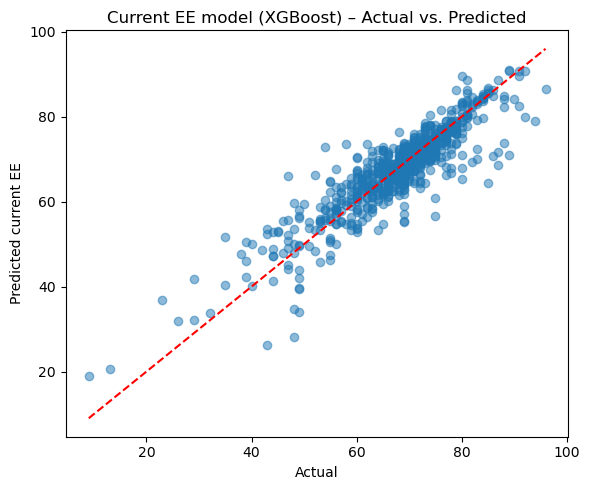


Potential gain model (XGBoost)
Mean Absolute Error: 4.9109
Mean Squared Error : 44.6437
RMSE               : 6.6816
R² Score           : -0.0224


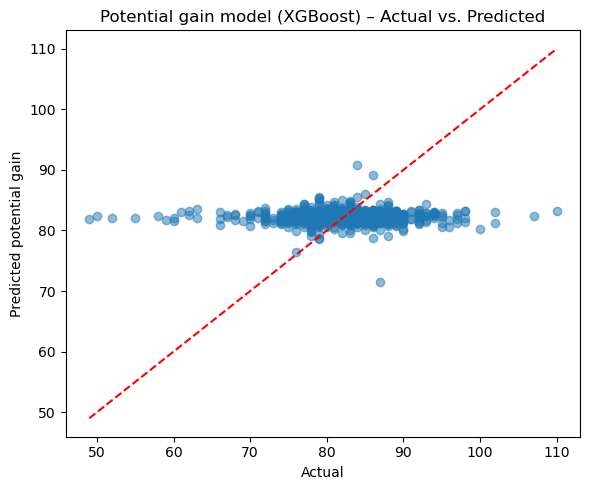

In [10]:
def eval_and_plot(model, X_test, y_test, title, y_label):
    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2  = r2_score(y_test, y_pred)

    print(f"\n{title}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error : {mse:.4f}")
    print(f"RMSE               : {rmse:.4f}")
    print(f"R² Score           : {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    mn = min(y_test.min(), y_pred.min())
    mx = max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.xlabel("Actual")
    plt.ylabel(y_label)
    plt.title(f"{title} – Actual vs. Predicted")
    plt.tight_layout()
    plt.show()

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}


# --- Run for both models ---
metrics_current = eval_and_plot(
    current_model,
    X_test,
    y_cur_test,
    title="Current EE model (XGBoost)",
    y_label="Predicted current EE"
)

metrics_potential = eval_and_plot(
    potential_model,
    X_test,
    y_pot_test,
    title="Potential gain model (XGBoost)",
    y_label="Predicted potential gain"
)


### Save useful model

In [11]:
# Save the current model and feature columns
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# 1) Save pipeline (preprocess + model weights)
joblib.dump(current_model, os.path.join(MODEL_DIR, "xgboost_ee_model.joblib"))

# 2) Save expected raw input columns (so API can align payload)
feature_columns = list(X.columns)
with open(os.path.join(MODEL_DIR, "feature_columns.json"), "w", encoding="utf-8") as f:
    json.dump(feature_columns, f, ensure_ascii=False, indent=2)